CatsDogs Cats and Dogs binary classification using Pytorch, its a baseline CNN model. In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

Link -->> https://www.kaggle.com/c/dogs-vs-cats

In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import torch
import zipfile
import matplotlib.pyplot as plt 
import torchvision
from torchvision.utils import make_grid 
from torchvision.models import resnet50 
from sklearn.model_selection import train_test_split 
import torch.nn as nn 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image

torch.manual_seed(42)

In [2]:


train_file = '/home/db/jupyter_projects/CatsDogstrain'
test_file = '/home/db/jupyter_projects/CatsDogstest'

train_list = glob.glob(os.path.join(train_file,'*.jpg')) # Get list of all jpg files/dirs in data folder trian_dir
test_list = glob.glob(os.path.join(test_file, '*.jpg'))

In [3]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [4]:
print(os.listdir(train_file)[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


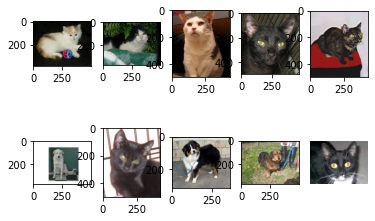

In [5]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


In [7]:
label = [path.split('/')[-1].split('.')[0] for path in train_list]

In [8]:
print(type(label))

<class 'list'>


In [9]:
train_list[6071].split('/')[-1].split('.')[0]

'cat'

In [10]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [11]:
print(len(train_list))
print(len(val_list))

20000
5000


In [12]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor()
    ])


In [13]:
class dataset(torch.utils.data.Dataset):
   
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label


In [14]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [46]:
trainloader = torch.utils.data.DataLoader(dataset = train_data, batch_size=8, shuffle=True )
testloader = torch.utils.data.DataLoader(dataset = test_data, batch_size=18, shuffle=False)
validloader = torch.utils.data.DataLoader(dataset = val_data, batch_size=8, shuffle=False)

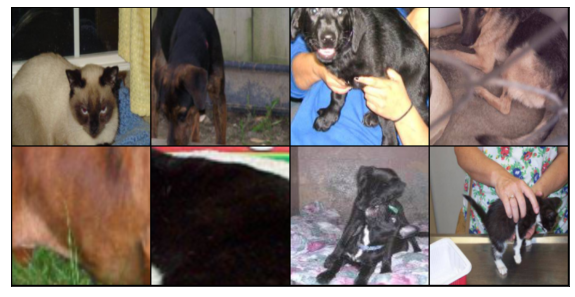

In [47]:
for images, labels in trainloader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [48]:
print(len(validloader))
print(len(trainloader))
print(len(testloader))

625
2500
695


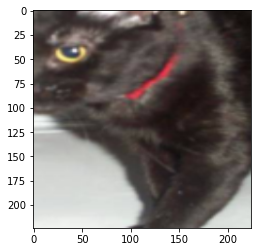

In [49]:
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))

In [50]:
print(f"Train data: {len(train_data)}, Train loader: {len(trainloader)}")


Train data: 20000, Train loader: 2500


In [51]:
print(f"Val data: {len(val_data)}, Val loader: {len(validloader)}")

Val data: 5000, Val loader: 625


In [52]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [53]:
class VGG16(nn.Module):   #batchsize=8, lr=1-4
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) 
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [54]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            epoch_loss += loss.item()
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

In [60]:

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model = VGG16().to(device=device)
model.train()
optimizer = optim.Adam(params = model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [61]:
TrainingLoop(
    epoch=10,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    trainloader=trainloader,

)

Loss in epoch 1 : 0.6933239218235016 : date and time : 2022-04-01 17:36:32.843348
Loss in Valid epoch 1 : 0.6930726856231689 : Got 2544 / 5000 with valid accuracy of :50.88
Loss in epoch 10 : 0.6931645765304565 : date and time : 2022-04-01 18:46:03.227039
Loss in Valid epoch 10 : 0.6931412292480469 : Got 2469 / 5000 with valid accuracy of :49.38


In [62]:
#torch.save(model.state_dict(), "/home/db/jupyter_projects/CatsDogs/catsdog_VGG16.pt")

In [63]:
model = VGG16().to(device="cpu")
#model.load_state_dict(torch.load("/home/db/jupyter_projects/CatsDogs/catsdog_VGG16.pt"))
model.eval()

VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 51

In [64]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in testloader:
        data = data.to(device="cpu")
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))
    

In [65]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('1', 0.5086382627487183),
 ('2', 0.49663132429122925),
 ('3', 0.49799180030822754),
 ('4', 0.5026682019233704),
 ('5', 0.5033525228500366),
 ('6', 0.5028069615364075),
 ('7', 0.5018406510353088),
 ('8', 0.5069186091423035),
 ('9', 0.49922022223472595),
 ('10', 0.5008912682533264),
 ('11', 0.49709174036979675),
 ('12', 0.5051299929618835),
 ('13', 0.5005505084991455),
 ('14', 0.4969572424888611),
 ('15', 0.5003432631492615),
 ('16', 0.49968791007995605),
 ('17', 0.5002425312995911),
 ('18', 0.5008155107498169),
 ('19', 0.5013445019721985),
 ('20', 0.5009535551071167),
 ('21', 0.5019657611846924),
 ('22', 0.5006539821624756),
 ('23', 0.5019453167915344),
 ('24', 0.4998094141483307),
 ('25', 0.5018264055252075),
 ('26', 0.49819159507751465),
 ('27', 0.49986669421195984),
 ('28', 0.4990743398666382),
 ('29', 0.5000757575035095),
 ('30', 0.49997103214263916),
 ('31', 0.4994323253631592),
 ('32', 0.5015223026275635),
 ('33', 0.49723780155181885),
 ('34', 0.5020348429679871),
 ('35', 0.4987